In [220]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp


In [221]:
#Data import - clean, seperate & filter
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet("training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)

pandas.core.frame.DataFrame

In [222]:
print(df_train_detached.head())


  Property_ID           Timestamp half-hour  Boiler_Energy_Output  \
0     EOH0279 2020-10-26 00:00:00  00:00:00                   NaN   
1     EOH1703 2020-10-26 00:00:00  00:00:00                   NaN   
2     EOH1703 2020-10-26 00:30:00  00:30:00                   NaN   
3     EOH0279 2020-10-26 00:30:00  00:30:00                   NaN   
4     EOH0279 2020-10-26 01:00:00  01:00:00                   NaN   

   Circulation_Pump_Energy_Consumed  Heat_Pump_Energy_Output  \
0                             0.000                    0.000   
1                             0.013                    0.242   
2                             0.029                    0.622   
3                             0.000                    0.000   
4                             0.000                    2.730   

   Whole_System_Energy_Consumed  External_Air_Temperature  \
0                         0.008                      9.38   
1                         0.078                      7.08   
2                

In [223]:
id_use = "EOH0279"
df_single = df_train_detached[df_train_detached["Property_ID"] == id_use]

In [224]:
print(df_single.head())
#df_single.isna().sum()

  Property_ID           Timestamp half-hour  Boiler_Energy_Output  \
0     EOH0279 2020-10-26 00:00:00  00:00:00                   NaN   
3     EOH0279 2020-10-26 00:30:00  00:30:00                   NaN   
4     EOH0279 2020-10-26 01:00:00  01:00:00                   NaN   
6     EOH0279 2020-10-26 01:30:00  01:30:00                   NaN   
9     EOH0279 2020-10-26 02:00:00  02:00:00                   NaN   

   Circulation_Pump_Energy_Consumed  Heat_Pump_Energy_Output  \
0                               0.0                    0.000   
3                               0.0                    0.000   
4                               0.0                    2.730   
6                               0.0                    4.312   
9                               0.0                    4.312   

   Whole_System_Energy_Consumed  External_Air_Temperature  \
0                         0.008                      9.38   
3                         0.019                      9.33   
4                

In [225]:
df_single[df_single["SolarRadiation"].isna()]

,Property_ID,Timestamp,half-hour,Boiler_Energy_Output,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,...,Postcode,Time,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed
63885,EOH0279,2021-03-24 00:30:00,00:30:00,NaN,16.325,7866.496,2554.229,5.94,23.16,23.38,...,EH22,00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63903,EOH0279,2021-03-24 01:30:00,01:30:00,NaN,16.325,7868.529,2555.274,5.48,47.13,39.16,...,EH22,01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63929,EOH0279,2021-03-24 02:30:00,02:30:00,NaN,16.325,7868.529,2555.294,5.25,33.21,32.74,...,EH22,02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63949,EOH0279,2021-03-24 03:30:00,03:30:00,NaN,16.325,7868.529,2555.315,5.13,28.42,28.77,...,EH22,03:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63964,EOH0279,2021-03-24 04:30:00,04:30:00,NaN,16.325,7868.529,2555.336,4.88,25.83,26.33,...,EH22,04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415687,EOH0279,2023-03-26 19:30:00,19:30:00,NaN,79.706,27418.700,8179.191,1.82,26.66,25.57,...,EH22,19:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415711,EOH0279,2023-03-26 20:30:00,20:30:00,NaN,79.723,27420.354,8179.661,2.06,23.32,23.33,...,EH22,20:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415726,EOH0279,2023-03-26 21:30:00,21:30:00,NaN,79.741,27420.354,8179.788,2.39,18.75,18.80,...,EH22,21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415748,EOH0279,2023-03-26 22:30:00,22:30:00,NaN,79.758,27420.354,8179.915,2.51,17.14,17.20,...,EH22,22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

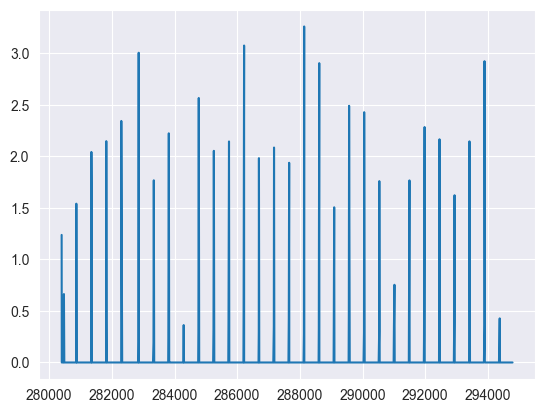

In [226]:
#Isolate water usage
t_start = pd.to_datetime("2022-06-18")
t_end = pd.to_datetime("2022-07-18")


df_isolate = df_single[df_single["Timestamp"] >= t_start]
df_isolate = df_isolate[df_isolate["Timestamp"] <= t_end]
#df_isolate["Heat_Pump_Energy_Output_Diff"].plot()
df_isolate["Heat_Pump_Energy_Output"].diff().plot()

In [227]:
id_use = "EOH0279"
df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] - 
     df_single["Internal_Air_Temperature"])
     


# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
print("Columns dropped due to high missing values:")
print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

print("\nColumns remaining after dropping highly missing columns:")
print(df_single.columns.tolist())

# 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy() 
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

print(f"\nNumber of rows dropped after handling NA values (missing for > 2 hours): {rows_dropped_after_interpolation}")


# 3. Split 80% to train and 20% to validate (based on time)
train_size = 0.8
split_point = int(len(df_single_processed) * train_size)

train_df = df_single_processed.iloc[:split_point].copy()
val_df = df_single_processed.iloc[split_point:].copy()

print(f"\nTrain data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Train data date range: {train_df.index.min()} to {train_df.index
      .max()}")
print(f"Validation data date range: {val_df.index.min()} to {val_df.index
.max()}")


# 4. Split the data between night and day
# Assuming night is from 10 PM (22:00) to 6 AM (06:00) AND SolarRadiation is 0.

# Extract hour from Timestamp
df_train_single = train_df.copy()
df_train_single['Hour'] = train_df.index.hour

# Define night and day conditions
# Condition 1: Time is between 10 PM and 6 AM
night_time_condition = (df_train_single['Hour'] >= 22) | \
                       (df_train_single['Hour'] < 6)

# Condition 2: Solar Irradiation is 0 (assuming 'SolarRadiation' is the correct column name)
if 'SolarRadiation' in df_train_single.columns:
    night_solar_condition = (df_train_single['SolarRadiation'] == 0)
    df_train_single['is_night'] = night_time_condition & night_solar_condition
else:
    print("\nWarning: 'SolarRadiation' column not found after preprocessing. Cannot use it for night/day split.")
    df_train_single['is_night'] = night_time_condition # Fallback to just time condition

day_df = df_train_single[df_train_single['is_night'] == False]
night_df = df_train_single[df_train_single['is_night'] == True]

print(f"\nDay data shape: {day_df.shape}")
print(f"Night data shape: {night_df.shape}")

print("\nExample of Day data head:")
print(day_df.head())
print("\nExample of Night data head:")
print(night_df.head())

Columns dropped due to high missing values:
['Back-up_Heater_Energy_Consumed', 'Boiler_Energy_Output', 'Brine_Flow_Temperature', 'Brine_Return_Temperature']

Columns remaining after dropping highly missing columns:
['Property_ID', 'Timestamp', 'half-hour', 'Circulation_Pump_Energy_Consumed', 'Heat_Pump_Energy_Output', 'Whole_System_Energy_Consumed', 'External_Air_Temperature', 'Heat_Pump_Heating_Flow_Temperature', 'Heat_Pump_Return_Temperature', 'Internal_Air_Temperature', 'Hot_Water_Flow_Temperature', 'Immersion_Heater_Energy_Consumed', 'Date', 'has_data', 'Heat_Pump_Energy_Output_Diff', 'Postcode', 'Time', 'Temperature', 'FeelsLike', 'Humidity', 'Dew', 'Precipitation', 'SolarRadiation', 'SolarEnergy', 'Windspeed', 'Internal_Temperature_Diff', 'Internal_Ambient_Temperature_Diff']

Number of rows dropped after handling NA values (missing for > 2 hours): 8

Train data shape: (41010, 26)
Validation data shape: (10253, 26)
Train data date range: 2020-10-26 00:00:00 to 2023-02-27 09:30:00


<Axes: xlabel='Timestamp'>

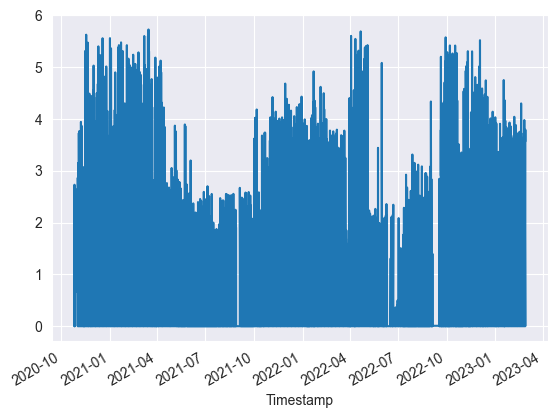

In [228]:
night_df["Heat_Pump_Energy_Output_Diff"].plot()

In [229]:
# Prep data inputs night
t_step = 30 # minutes
delta_t = t_step/60

#night
T_a_night = night_df["External_Air_Temperature"]
T_i_night = night_df["Internal_Air_Temperature"]
delta_T_a_night = night_df["Internal_Ambient_Temperature_Diff"]
delta_T_i_night = (night_df["Internal_Temperature_Diff"])/delta_t
q_hp_night = night_df["Heat_Pump_Energy_Output_Diff"]
q_solar_night = night_df["SolarRadiation"]
v_wind_night = night_df["Windspeed"]


#day
T_a_day = day_df["External_Air_Temperature"]
T_i_day = day_df["Internal_Air_Temperature"]
delta_T_a_day = day_df["Internal_Ambient_Temperature_Diff"]
delta_T_i_day = (day_df["Internal_Temperature_Diff"])/delta_t
q_hp_day = day_df["Heat_Pump_Energy_Output_Diff"]
q_solar_day = day_df["SolarRadiation"]
v_wind_day = day_df["Windspeed"]


In [230]:
trained_params = pd.DataFrame(index = ["C","R_a","w_n","w_d","w_solar","w_wind",
                                       "rmse_n","rmse_d"])
trained_params

""
C
R_a
w_n
w_d
w_solar
w_wind
rmse_n
rmse_d


In [231]:
# --- Linear Regression Formulation 1R1C C delta_T_i = (T_a - T_i)/R_a + q + w ---

# For night:
# C * dTi/dt = 1/Ra * (Ta - Ti) + q_hp + w_night
# Rearranging to Y = X * theta:
# dTi/dt = (1/(C*Ra)) * (Ta - Ti) + (1/C) * q_hp + (1/C) * w_night
# So, Y = dTi/dt
# X = [(Ta - Ti), q_hp, 1]
# theta = [1/(C*Ra), 1/C, w_night/C]

# 2) drop the *first* row so that ∆T_i at time t lines up with inputs at time t-1
Y_night = delta_T_i_night.iloc[1:].reset_index(drop=True)

# 3) build your regressors at time t-1 (so they match Y_night’s index)
X1 = delta_T_a_night.iloc[:-1].reset_index(drop=True)

X2 = q_hp_night.iloc[:-1].reset_index(drop=True)

X3 = np.ones_like(X1)   # constant term

# 4) stack into design matrix and solve
X_night = np.column_stack([X1, X2, X3])
theta_n, residuals_n, rank, s = lstsq(X_night, Y_night)

# 5) recover parameters
alpha, beta, gamma = theta_n   # [1/(C·R), 1/C, w_n/C]
C     = 1.0 / beta
R_a   = beta / alpha
w_n   = gamma * C
rmse_n  = np.sqrt(residuals_n / len(Y_night))

print(f"From night:R_a = {R_a:.3f}, C = {C:.3f}, w_night = {w_n:.3f}, RMSE = "
      f"{rmse_n:.4f}")


#-----Day training-------
Y_day_1 = C * delta_T_i_day.iloc[1:].reset_index(drop=True) 
Y_day_2 = delta_T_a_day.iloc[:-1].reset_index(drop=True) / R_a 
Y_day_3 = q_hp_day.iloc[:-1].reset_index(drop=True)

Y_day = Y_day_1 - Y_day_2 - Y_day_3

X_day = np.ones((len(Y_day), 1))  # constant term


theta_d, residuals_d, rank_d, s_d = lstsq(X_day, Y_day)

w_d   = theta_d[0]
rmse_d  = np.sqrt(residuals_d / len(Y_day))

print(f"From day: w_day = {w_d:.3f}, "
      f"RMSE = "
      f"{rmse_d:.4f}")

trained_params["v1"] = [C,R_a,w_n,w_d,"NA","NA",rmse_n,rmse_d]


From night:R_a = 4.197, C = 10.785, w_night = -0.059, RMSE = 0.1798
From day: w_day = 1.920, RMSE = 3.4168


In [232]:
trained_params["v1"]["C"]

np.float64(10.784503943511211)

In [233]:
#Linear Regression Formulation 1R1C 
# C delta_T_i = (T_a - T_i)/R_a + q + w + w_solar*q_solar
# ----- With solar-------

# For night, same as before
print(f"From night:R_a = {trained_params["v1"]["R_a"]:.3f}, C = "
      f"{trained_params["v1"]["C"]:.3f}, w_night = "
      f"{trained_params["v1"]["w_n"]:.3f}, RMSE = "
      f"{trained_params["v1"]["rmse_n"]:.4f}")

#For day:
#C* delta_T_i - (T_a - T_i)/(R_a) - q  = w_day + w_solar * q_solar

#-----Day training-------
Y_day_1 = C * delta_T_i_day.iloc[1:].reset_index(drop=True) 
Y_day_2 = delta_T_a_day.iloc[:-1].reset_index(drop=True) / R_a 
Y_day_3 = q_hp_day.iloc[:-1].reset_index(drop=True)

Y_day = Y_day_1 - Y_day_2 - Y_day_3


X_2 = q_solar_day.iloc[:-1].reset_index(drop=True)
X_1 = np.ones_like(X_2)  # constant term

X_day = np.column_stack([X_1, X_2])

theta_d, residuals_d, rank_d, s_d = lstsq(X_day, Y_day)

w_d   = theta_d[0]
w_solar = theta_d[1]
rmse_d  = np.sqrt(residuals_d / len(Y_day))

print(f"From day: w_day = {w_d:.3f}, w_solar = {w_solar:.3f},"
      f"RMSE = {rmse_d:.4f}")

trained_params["v2"] = [trained_params["v1"]["C"],
                        trained_params["v1"]["R_a"],
                        trained_params["v1"]["w_n"],w_d,
                        w_solar, "NA", trained_params["v1"]["rmse_n"],rmse_d]

From night:R_a = 4.197, C = 10.785, w_night = -0.059, RMSE = 0.1798
From day: w_day = 2.114, w_solar = -0.001,RMSE = 3.4065


In [234]:
#Linear Regression Formulation 1R1C 
# C delta_T_i = (T_a - T_i)/R_a + q + w + w_wind*v_wind
# ----- With wind method 1-------

delta_T_a_night = T_a_night(0:end-1) - T_i_night(0:end-1)
delta_T_i_night = (T_i_night(1:end)-T_i_night(0:end-1))/delta_t

#For night
#delta_T_i = (T_a - T_i)/(C*)R_a + 1/C * q + 1/C* w_night + 1/C*w_wind*v_wind

Y_night = delta_T_i_night
X_night = [delta_T_a_night(0:end-1), q_hp_night(0:end-1), -ones(len(T_i_night
                          (0:end-1))), v_wind_night(0:end-1)]

theta_night,residuals_night,rank_night,s_night = lstsq(X_night,Y_night)
C = 1/theta_night[1]
R_a = theta_night[1]/theta_night[0]
w_night = C*theta_night[3]
w_wind = C*theta_night[4]

print("R_a:",R_a)
print("C:",C)
print("disturbance night, w_night:", w_night)
print("Residuals (RMSE)", residuals_night)


#For day:
#C* delta_T_i - (T_a - T_i)/(R_a) - q  = w_day
delta_T_a_day = T_a_day(0:end-1) - T_i_day(0:end-1)
delta_T_i_day = (T_i_day(1:end)-T_i_day(0:end-1))/delta_t



Y_day = C*delta_T_i_day - (delta_T_a_day(0:end-1))/R_a - q_hp_day(0:end-1) (- 
                                                w_wind*v_wind(0:end-1))
X_day = [ones(len(T_i_day(0:end-1)))]

theta_day,residuals_day,rank_day,s_day = lstsq(X_day,Y_day)
w_day = theta_day[0]
print("W_day:", w_day)
print("Residuals (RMSE)", residuals_day)

C_v3 = C
R_a_v3 = R_a
w_night_v3 = w_night
w_wind_v3 = w_wind
w_day_v3 = w_day

RMSE_night_v3 = residuals_night
RMSE_day_v3 = residuals_day

SyntaxError: invalid syntax (861956984.py, line 5)

In [ ]:
#Linear Regression Formulation 1R1C 
# C delta_T_i = (T_a - T_i)/R_a + q + w + w_wind*v_wind*(T_a - T_i)/R_a
# ----- With wind method 2-------

delta_T_a_night = T_a_night(0:end-1) - T_i_night(0:end-1)
delta_T_i_night = (T_i_night(1:end)-T_i_night(0:end-1))/delta_t

#For night
#delta_T_i = (T_a - T_i)/(C*R_a) + 1/C * q + 1/C* w_night + 1/
# (C*R_a) w_wind*v_wind*(T_a - T_i)

Y_night = delta_T_i_night
X_night = [delta_T_a_night(0:end-1), q_hp_night(0:end-1), -ones(len(T_i_night
                          (0:end-1))), v_wind_night(0:end-1)*delta_T_a_night(0:end-1)]

theta_night,residuals_night,rank_night,s_night = lstsq(X_night,Y_night)
C = 1/theta_night[1]
R_a = theta_night[1]/theta_night[0]
w_night = C*theta_night[3]
w_wind = C*R_a*theta_night[4]

print("R_a:",R_a)
print("C:",C)
print("disturbance night, w_night:", w_night)
print("Residuals (RMSE)", residuals_night)


#For day:
#C* delta_T_i - (T_a - T_i)/(R_a) - q  = w_day
delta_T_a_day = T_a_day(0:end-1) - T_i_day(0:end-1)
delta_T_i_day = (T_i_day(1:end)-T_i_day(0:end-1))/delta_t



Y_day = C*delta_T_i_day - (delta_T_a_day(0:end-1))/R_a - q_hp_day(0:end-1) (- 
                                                w_wind*v_wind_day(0:end-1)
                                                *delta_T_a_day(0:end-1)/R_a)
X_day = [ones(len(T_i_day(0:end-1)))]

theta_day,residuals_day,rank_day,s_day = lstsq(X_day,Y_day)
w_day = theta_day[0]
print("W_day:", w_day)
print("Residuals (RMSE)", residuals_day)

C_v4 = C
R_a_v4 = R_a
w_night_v4 = w_night
w_wind_v4 = w_wind
w_day_v4 = w_day
RMSE_night_v4 = residuals_night
RMSE_day_v4 = residuals_day

In [ ]:
#Linear Regression Formulation 1R1C 
# C delta_T_i = (T_a - T_i)/R_a + q + w + w_wind*v_wind*(T_a - T_i)/R_a
# ----- With wind and solar -------

delta_T_a_night = T_a_night(0:end-1) - T_i_night(0:end-1)
delta_T_i_night = (T_i_night(1:end)-T_i_night(0:end-1))/delta_t

#For night
#delta_T_i = (T_a - T_i)/(C*R_a) + 1/C * q + 1/C* w_night + 1/
# (C*R_a) w_wind*v_wind*(T_a - T_i) +  1/C * w_solar * q_solar

Y_night = delta_T_i_night
X_night = [delta_T_a_night(0:end-1), q_hp_night(0:end-1), -ones(len(T_i_night
                          (0:end-1))), v_wind_night(0:end-1)*delta_T_a_night
(0:end-1), q_solar]

theta_night,residuals_night,rank_night,s_night = lstsq(X_night,Y_night)
C = 1/theta_night[1]
R_a = theta_night[1]/theta_night[0]
w_night = C*theta_night[3]
w_wind = C*R_a*theta_night[4]
w_solar = C*theta_night[5]

print("R_a:",R_a)
print("C:",C)
print("disturbance night, w_night:", w_night)
print("disturbance solar, w_solar:", w_solar)
print("Residuals (RMSE)", residuals_night)


#For day:
#C* delta_T_i - (T_a - T_i)/(R_a) - q - 1/R_a * w_wind * v_wind*delta_T_a + 
# w_solar * q_solar = w_day
delta_T_a_day = T_a_day(0:end-1) - T_i_day(0:end-1)
delta_T_i_day = (T_i_day(1:end)-T_i_day(0:end-1))/delta_t



Y_day = C*delta_T_i_day - (delta_T_a_day(0:end-1))/R_a - q_hp_day(0:end-1) (- 
                                                w_wind*v_wind_day(0:end-1)
                                                *delta_T_a_day(0:end-1)/R_a +
                                                                        w_solar*q_solar)
X_day = [ones(len(T_i_day(0:end-1)))]

theta_day,residuals_day,rank_day,s_day = lstsq(X_day,Y_day)
w_day = theta_day[0]
print("W_day:", w_day)
print("Residuals (RMSE)", residuals_day)

C_v5 = C
R_a_v5 = R_a
w_night_v5 = w_night
w_wind_v5 = w_wind
w_solar_v5 = w_solar
w_day_v5 = w_day
RMSE_night_v5 = residuals_night
RMSE_day_v5 = residuals_day

In [ ]:
#Linear Regression Formulation 2R2C

In [ ]:
#Linear Regression Formulation 2R2C

In [ ]:
#Genetic algorithm formulation 3R2C

In [ ]:
#